<img src="img/dslogo.png" alt="title" align="right">

# Estudio de las variables explicativas del SQR

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Cargamos las librerías necesarias
from sklearn import preprocessing
from statistics import mode
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.options.display.max_rows = 180

In [5]:
# Cargamos datos con SQR
perfiles_sqr = pd.read_parquet('../data/processed/perfiles_sqr_filtrado.parquet')
perfiles_sqr.reset_index(drop=True, inplace=True) # reseteamos el índice

In [6]:
# perfiles_sqr.head()
perfiles_sqr['IMC'] = perfiles_sqr['peso'] / (perfiles_sqr['altura']/100)**2
perfiles_sqr['IMC_cat'] = pd.cut(perfiles_sqr['IMC'], bins=[0, 25, 30, 50],
                                include_lowest=True,labels=['Bajo peso', 'Normal', 'Sobrepeso'])
# tubos
for i in range(6):
    perfiles_sqr[f'PresPos{i+1}'] = perfiles_sqr.presiones.apply(lambda x: x[i])

In [7]:
sns.set_style('dark')

## Análisis univariante

### SQR

El SQR está centrado en torno al 70-75% como refleja el siguiente histograma y sus valores de media (72.14%) y de mediana (74.26%). El valor del cuantil 9 es 50.76%, es decir, sólo un 9% de los individuos obtienen un SQR menor del 50%. El primer cuartil (25) es 63.44, lo que implica que un 75% de los usuarios logran una calidad del sueño superior al 63%.

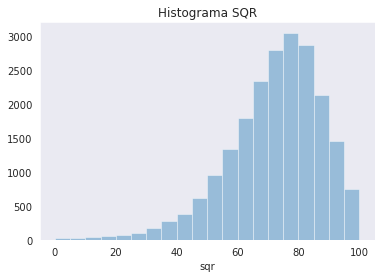

In [8]:
sns.distplot(perfiles_sqr["sqr"], bins=20,kde = False,hist=True)
plt.title("Histograma SQR")
plt.show();

In [9]:
display(pd.DataFrame(perfiles_sqr["sqr"].describe()).round(2).rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns'))

,sqr
count,21219.00
mean,72.14
std,15.41
min,0.02
25%,63.45
50%,74.26
75%,83.09
max,99.86


In [10]:
display(pd.DataFrame(perfiles_sqr["sqr"].quantile([0,0.08,0.09,0.1,0.2])))

,sqr
0.00,0.018056
0.08,49.469048
0.09,50.767978
0.10,51.989448
0.20,60.479507


### Sexo

Entre los usuarios el número de hombres es ligeramente superior al de mujeres (55% vs 45%) pero está bastante equilibrado.

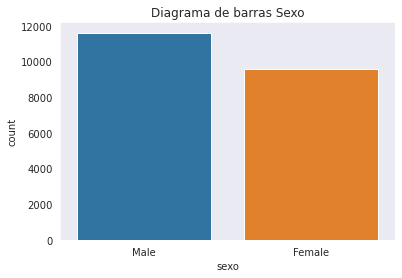

In [11]:
sns.countplot(x='sexo', data=perfiles_sqr)
plt.title("Diagrama de barras Sexo")
plt.show();

In [12]:
display(pd.DataFrame(perfiles_sqr["sexo"].value_counts()))

,sexo
Male,11617
Female,9602


### Posición

El 71% de los usuarios duerme en posición lateral frente al 29% que duerme en posición supine.

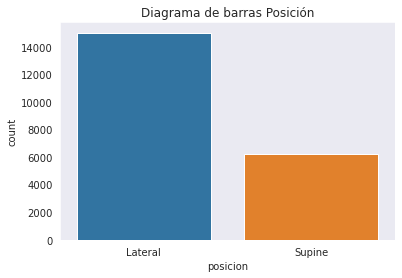

In [13]:
sns.countplot(x='posicion', data=perfiles_sqr)
plt.title("Diagrama de barras Posición")
plt.show();

In [14]:
display(pd.DataFrame(perfiles_sqr["posicion"].value_counts()))

,posicion
Lateral,15013
Supine,6206


### Altura

La altura muestra una distribución simétrica centrada en 170 cm.

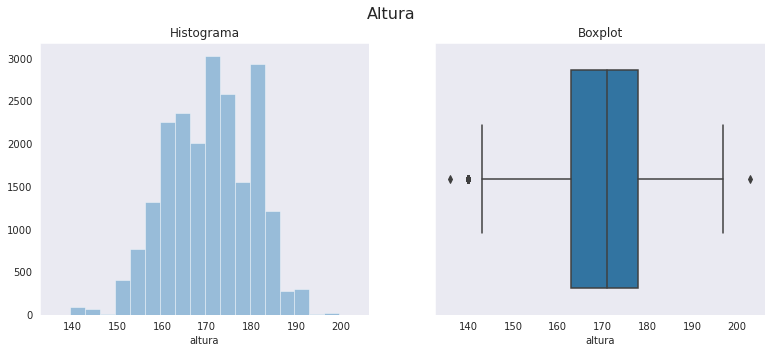

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False,figsize=(13,5))
sns.distplot(perfiles_sqr["altura"], bins=20,kde = False,hist=True, ax = ax1).set_title('Histograma')
sns.boxplot(perfiles_sqr["altura"], ax = ax2).set_title('Boxplot')
fig.suptitle('Altura', fontsize=16)
plt.show();

In [16]:
display(pd.DataFrame(perfiles_sqr["altura"].describe()))

,altura
count,21219.000000
mean,170.462416
std,9.474278
min,136.000000
25%,163.000000
50%,171.000000
75%,178.000000
max,203.000000


### Peso

El peso medio de los usuarios es de unos 74 kg. Se encuentran algunos valores atípicos a partir de los 120 kg.

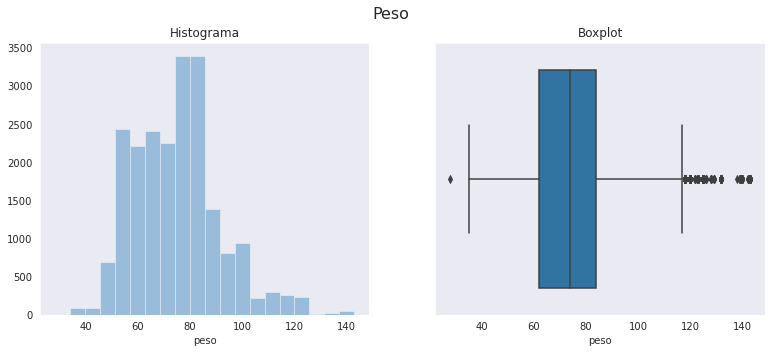

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False,figsize=(13,5))
sns.distplot(perfiles_sqr["peso"], bins=20,kde = False,hist=True, ax = ax1).set_title('Histograma')
sns.boxplot(perfiles_sqr["peso"], ax = ax2).set_title('Boxplot')
fig.suptitle('Peso', fontsize=16)
plt.show();

In [18]:
display(pd.DataFrame(perfiles_sqr["peso"].describe()))

,peso
count,21219.000000
mean,74.338706
std,16.564971
min,28.000000
25%,62.000000
50%,74.000000
75%,84.000000
max,143.000000


### IMC

Se calcula el IMC (Índice de Masa Corporal) a partir de la altura y el peso. Se categoriza dicha variable en 3 categorías:
* Bajo peso si IMC < 25
* Normal si IMC está entre 25 y 30
* Sobrepeso si el IMC es superior a 30

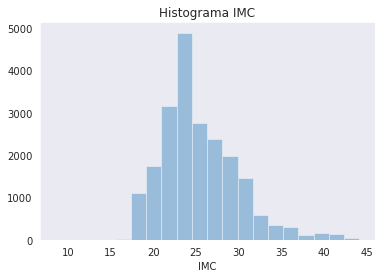

In [19]:
sns.distplot(perfiles_sqr["IMC"], bins=20,kde = False,hist=True)
plt.title("Histograma IMC")
plt.show();

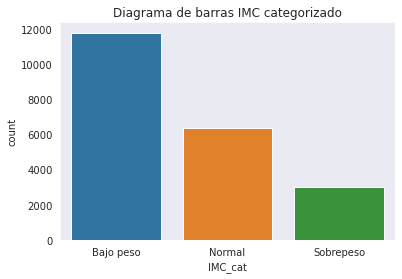

In [20]:
sns.countplot(x='IMC_cat', data=perfiles_sqr)
plt.title("Diagrama de barras IMC categorizado")
plt.show();

In [21]:
display(pd.DataFrame(perfiles_sqr["IMC_cat"].value_counts()))

,IMC_cat
Bajo peso,11805
Normal,6393
Sobrepeso,3021


### Presiones

El siguiente gráfico muestra la frecuencia de uso de las 6 presiones posibles en cada uno de los 6 tubos. En el tubo 1 son más usadas las presiones bajas (0 y 1) al igual que en el tubo 6 (1 y 2) aunque en este la presión seleccionada es mayor. Por otro lado, en los tubos 2, 3, 4 y 5 las presiones más usadas son más altas (principalmente 2 y 3).

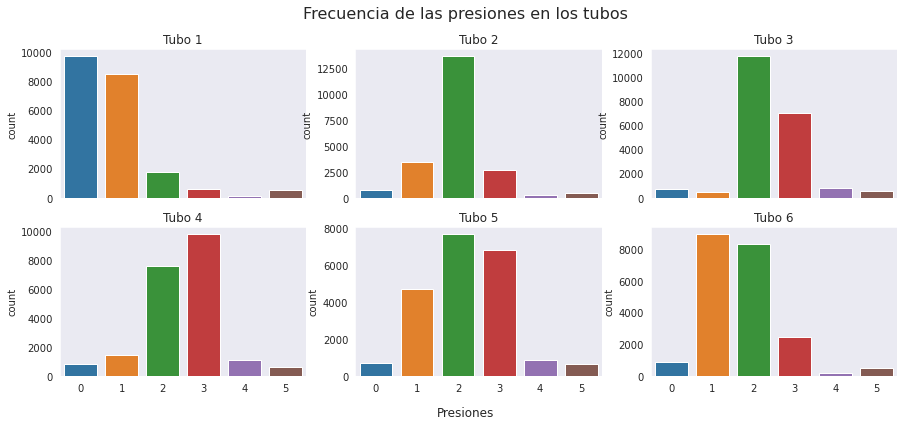

In [22]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.countplot(x='PresPos1', data=perfiles_sqr,ax=axs[0, 0]).set(title = 'Tubo 1',xlabel=None)
sns.countplot(x='PresPos2', data=perfiles_sqr,ax=axs[0, 1]).set(title = 'Tubo 2',xlabel=None)
sns.countplot(x='PresPos3', data=perfiles_sqr,ax=axs[0, 2]).set(title = 'Tubo 3',xlabel=None)
sns.countplot(x='PresPos4', data=perfiles_sqr,ax=axs[1, 0]).set(title = 'Tubo 4',xlabel=None)
sns.countplot(x='PresPos5', data=perfiles_sqr,ax=axs[1, 1]).set(title = 'Tubo 5',xlabel=None)
sns.countplot(x='PresPos6', data=perfiles_sqr,ax=axs[1, 2]).set(title = 'Tubo 6',xlabel=None)
fig.text(0.5, 0.04, 'Presiones', va='center', ha='center', fontsize=12)
fig.suptitle('Frecuencia de las presiones en los tubos', fontsize=16)
plt.show();

## Análisis bivariante

### Sexo con SQR

El SQR obtenido por las mujeres es ligeramente superior al de los hombres (media de 73 frente a 71.4).

In [23]:
display(perfiles_sqr.groupby('sexo').agg({'sqr': [min, max, 'mean', 'std', 'size'],}))

sqr                                        
             min        max       mean        std   size
sexo                                                    
Female  0.018056  99.581944  73.031235  14.280687   9602
Male    0.548611  99.859722  71.404368  16.253099  11617

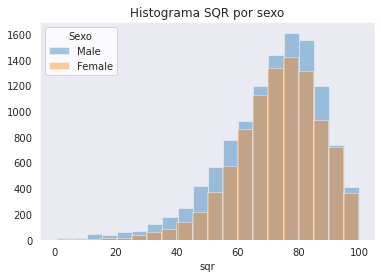

In [24]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['sexo']=="Male",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['sexo']=="Female",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR por sexo')
plt.legend(title='Sexo', loc='upper left', labels=['Male', 'Female'],facecolor = 'white')
plt.show();

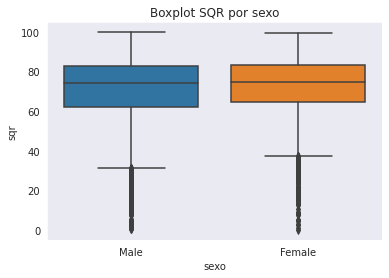

In [25]:
sns.boxplot(x="sexo", y="sqr",data=perfiles_sqr).set_title("Boxplot SQR por sexo")
plt.show();

### Posición con SQR

In [26]:
posicion_sqr = perfiles_sqr.groupby('posicion').describe().loc[:, 'sqr'].rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')
posicion_sqr['frecuencia relativa'] = posicion_sqr['frecuencia relativa'].astype(int)

In [27]:
display(posicion_sqr)

,frecuencia relativa,media,desviación,min,25%,50%,75%,max
posicion,,,,,,,,
Lateral,15013,72.607845,15.312401,0.548611,64.112296,74.783839,83.474616,99.720833
Supine,6206,71.010132,15.596523,0.018056,61.830082,72.988868,81.998622,99.859722


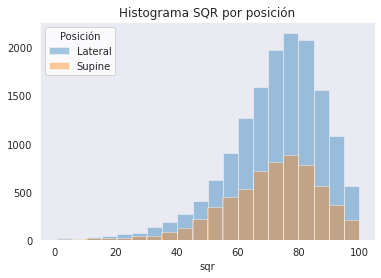

In [28]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['posicion']=="Lateral",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['posicion']=="Supine",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR por posición')
plt.legend(title='Posición', loc='upper left', labels=['Lateral', 'Supine'],facecolor = 'white')
plt.show();

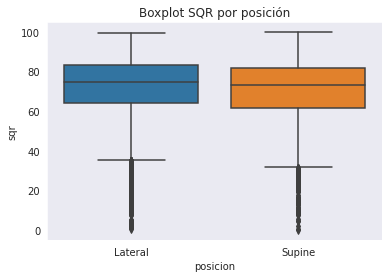

In [29]:
sns.boxplot(x="posicion", y="sqr",data=perfiles_sqr).set_title("Boxplot SQR por posición")
plt.show();

### IMC con SQR

Las personas con sobrepeso tienen un SQR medio menor que el de las personas con peso normal y con peso bajo.

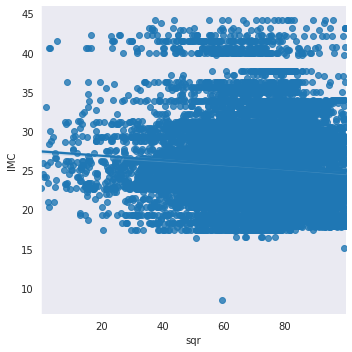

In [30]:
sns.lmplot(x="sqr", y="IMC", data=perfiles_sqr)
plt.show();

In [31]:
IMC_cat_sqr = perfiles_sqr.groupby('IMC_cat').describe().loc[:, 'sqr'].rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')
IMC_cat_sqr['frecuencia relativa'] = IMC_cat_sqr['frecuencia relativa'].astype(int)

In [32]:
display(IMC_cat_sqr)

,frecuencia relativa,media,desviación,min,25%,50%,75%,max
IMC_cat,,,,,,,,
Bajo peso,11805,73.306604,15.053869,0.018056,64.596349,75.208503,84.260745,99.859722
Normal,6393,71.194543,15.695081,0.627778,62.983884,73.873327,81.948612,99.581944
Sobrepeso,3021,69.585994,15.752310,1.523611,60.631906,71.692508,80.934330,99.581944


In [33]:
from scipy.stats import f_oneway
a = perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Bajo peso",'sqr']
b = perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Normal",'sqr']
c = perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Sobrepeso",'sqr']

In [34]:
f_oneway(a,b,c);

In [35]:
stats.kruskal(a,b,c);

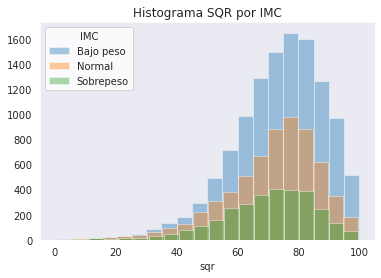

In [36]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Bajo peso",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Normal",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Sobrepeso",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR por IMC')
plt.legend(title='IMC', loc='upper left', labels=['Bajo peso', 'Normal', 'Sobrepeso'],facecolor = 'white')
plt.show();

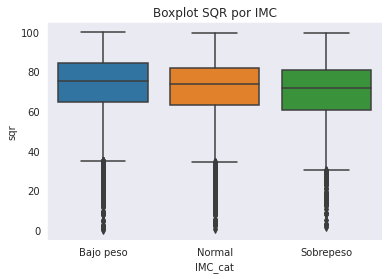

In [37]:
sns.boxplot(x="IMC_cat", y="sqr",data=perfiles_sqr).set_title("Boxplot SQR por IMC")
plt.show();

### Tubos con SQR

A continuación se muestra la distribución del SQR en función de la presión utilizada en cada uno de los tubos. Nótese que las presiones 4 y 5 son las menos utilizadas y, por tanto, su tamaño muestral es menor. Esto puede causar que sean los histogramas más variables.

#### Tubo 1

In [38]:
PresPos1_sqr = perfiles_sqr.groupby('PresPos1').describe().loc[:, 'sqr'].rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')
PresPos1_sqr['frecuencia relativa'] = PresPos1_sqr['frecuencia relativa'].astype(int)

In [39]:
display(PresPos1_sqr)

,frecuencia relativa,media,desviación,min,25%,50%,75%,max
PresPos1,,,,,,,,
0,9684,72.601943,15.090361,0.548611,64.270281,74.681732,83.310503,99.720833
1,8464,71.755330,15.535917,0.018056,62.814994,73.752242,82.967043,99.859722
2,1791,70.594354,16.243762,1.523611,61.544880,73.568583,81.721241,99.581944
3,628,74.177582,14.898699,5.200000,66.256986,75.376547,83.838817,99.581944
4,100,75.105263,14.771614,35.393210,66.305243,76.386425,85.815428,99.581944
5,552,72.115225,16.422189,7.991667,63.274859,74.684639,84.087934,99.566667


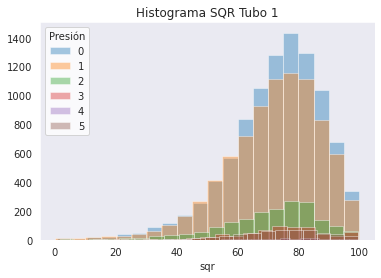

In [40]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 1')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show();

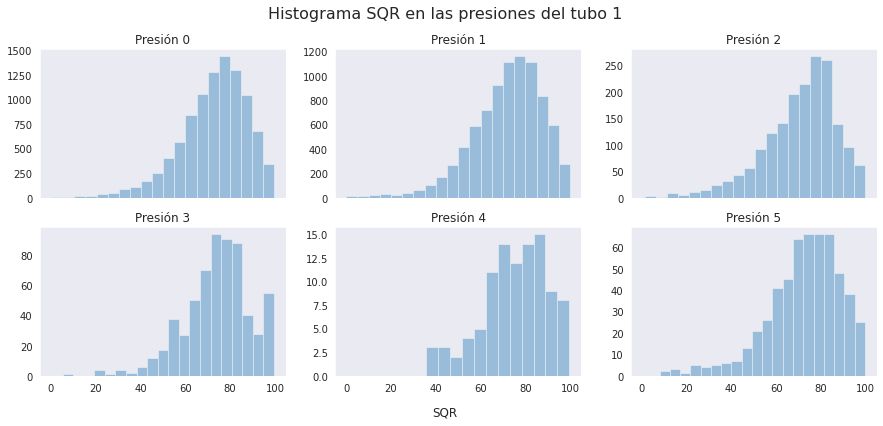

In [41]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="4",'sqr'], bins=12,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 1', fontsize=16)
plt.show();

#### Tubo 2

In [42]:
PresPos2_sqr = perfiles_sqr.groupby('PresPos2').describe().loc[:, 'sqr'].rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')
PresPos2_sqr['frecuencia relativa'] = PresPos2_sqr['frecuencia relativa'].astype(int)

In [43]:
display(PresPos2_sqr)

,frecuencia relativa,media,desviación,min,25%,50%,75%,max
PresPos2,,,,,,,,
0,730,73.104625,15.845595,2.769516,64.342043,75.954176,84.003116,99.581944
1,3405,71.578082,15.690513,2.319444,63.347154,73.873461,82.957895,99.581944
2,13663,72.570181,15.138626,0.018056,63.892067,74.584779,83.424356,99.859722
3,2664,68.869956,15.906255,1.523611,60.153525,71.100924,80.008698,99.581944
4,297,81.920981,13.345318,23.835269,76.368212,82.828856,91.053200,99.581944
5,460,74.639649,14.596860,7.991667,66.396787,75.537698,85.322456,99.566667


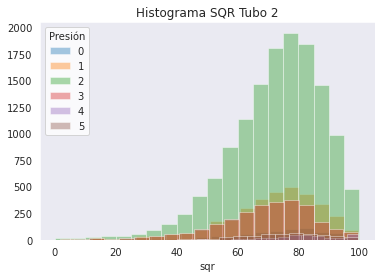

In [44]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 2')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show();

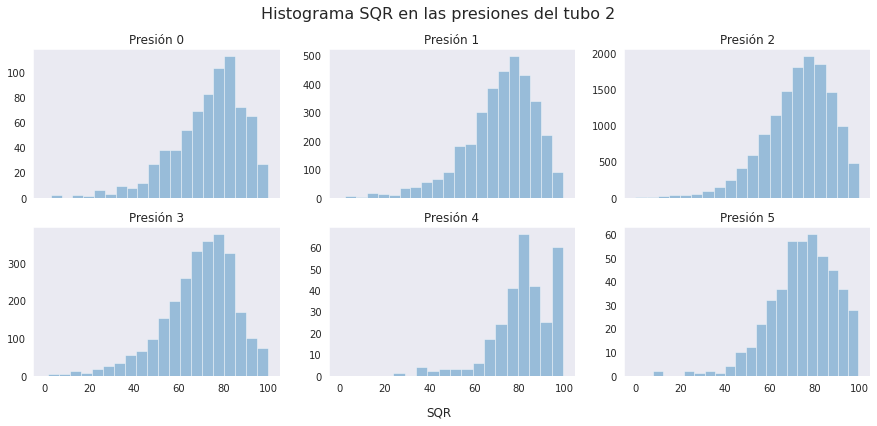

In [45]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="4",'sqr'], bins=15,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 2', fontsize=16)
plt.show();

#### Tubo 3

In [46]:
PresPos3_sqr = perfiles_sqr.groupby('PresPos3').describe().loc[:, 'sqr'].rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')
PresPos3_sqr['frecuencia relativa'] = PresPos3_sqr['frecuencia relativa'].astype(int)

In [47]:
display(PresPos3_sqr)

,frecuencia relativa,media,desviación,min,25%,50%,75%,max
PresPos3,,,,,,,,
0,740,72.882226,14.659433,2.769516,65.213097,74.692387,83.187663,99.581944
1,459,66.478631,20.167444,2.743056,54.465713,69.715050,82.385228,99.336111
2,11673,71.739676,15.234670,0.018056,62.834338,73.624789,82.761567,99.859722
3,6987,73.004088,15.177913,1.523611,65.094350,75.400113,83.501000,99.581944
4,775,73.607598,16.194871,12.990278,64.839615,75.448810,83.696812,99.581944
5,585,71.386737,16.014291,5.200000,61.923027,73.170415,83.300143,99.566667


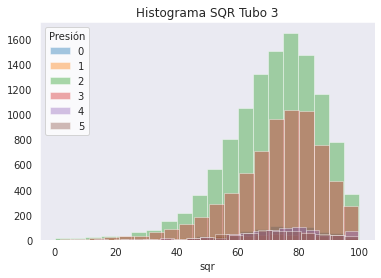

In [48]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 3')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show()

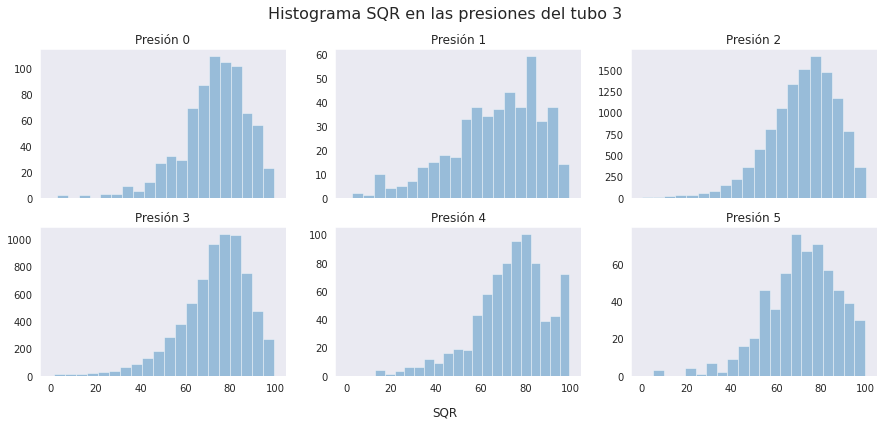

In [49]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="4",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 3', fontsize=16)
plt.show()

#### Tubo 4

In [50]:
PresPos4_sqr = perfiles_sqr.groupby('PresPos4').describe().loc[:, 'sqr'].rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')
PresPos4_sqr['frecuencia relativa'] = PresPos4_sqr['frecuencia relativa'].astype(int)

In [51]:
display(PresPos4_sqr)

,frecuencia relativa,media,desviación,min,25%,50%,75%,max
PresPos4,,,,,,,,
0,808,73.149089,14.962538,2.769516,65.037798,75.479361,83.956485,99.581944
1,1441,72.010057,16.836826,2.743056,61.987203,74.009949,83.844922,99.581944
2,7570,72.424461,14.808427,0.018056,63.700868,74.246351,83.233778,99.859722
3,9751,72.310961,15.581258,0.548611,63.964697,74.655567,83.158868,99.720833
4,1072,68.393368,15.656627,12.947659,60.048492,70.226577,79.725598,99.581944
5,577,71.411545,15.869846,5.200000,62.171237,73.319806,82.993196,99.566667


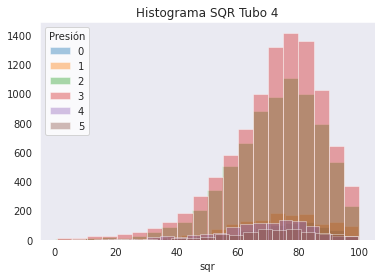

In [52]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 4')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show();

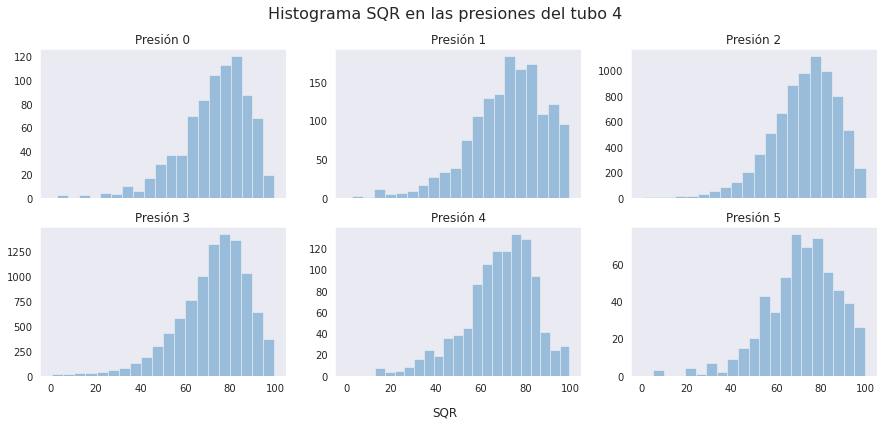

In [53]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="4",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 4', fontsize=16)
plt.show();

#### Tubo 5

In [54]:
PresPos5_sqr = perfiles_sqr.groupby('PresPos5').describe().loc[:, 'sqr'].rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')
PresPos5_sqr['frecuencia relativa'] = PresPos5_sqr['frecuencia relativa'].astype(int)

In [55]:
display(PresPos5_sqr)

,frecuencia relativa,media,desviación,min,25%,50%,75%,max
PresPos5,,,,,,,,
0,665,74.623691,15.425138,2.769516,66.241118,77.892981,85.534759,99.581944
1,4687,72.362595,15.032707,0.018056,63.622169,73.931859,83.016998,99.581944
2,7630,73.071392,14.229057,0.548611,65.139217,74.949029,83.081380,99.720833
3,6772,71.419228,16.408467,0.627778,62.085353,74.161755,83.263693,99.859722
4,824,66.341276,17.010318,1.523611,57.860845,67.900212,77.299903,99.559722
5,641,71.936466,16.561297,7.991667,62.987623,74.434963,84.118401,99.581944


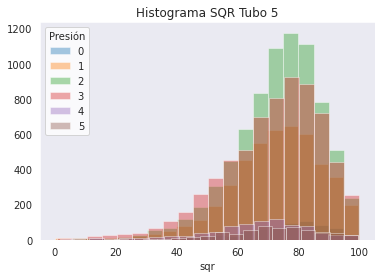

In [56]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 5')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show();

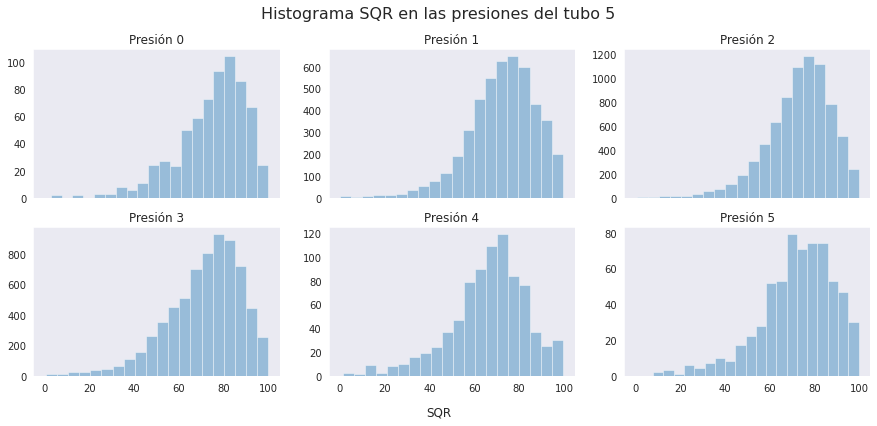

In [57]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="4",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 5', fontsize=16)
plt.show();

#### Tubo 6

In [58]:
PresPos6_sqr = perfiles_sqr.groupby('PresPos6').describe().loc[:, 'sqr'].rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')
PresPos6_sqr['frecuencia relativa'] = PresPos6_sqr['frecuencia relativa'].astype(int)

In [59]:
display(PresPos6_sqr)

,frecuencia relativa,media,desviación,min,25%,50%,75%,max
PresPos6,,,,,,,,
0,885,74.072956,14.524366,2.769516,65.911422,76.319321,84.258490,99.581944
1,8929,72.439487,14.311262,0.548611,64.239841,74.130864,82.511416,99.720833
2,8341,71.769776,16.267688,0.018056,62.267786,74.234814,83.658215,99.859722
3,2425,70.900409,16.757019,1.523611,62.106565,73.742055,81.996672,99.581944
4,177,74.601636,11.407603,40.709470,67.367799,73.751143,82.890637,99.559722
5,462,74.922135,14.811317,7.991667,66.925287,76.517184,85.322456,99.581944


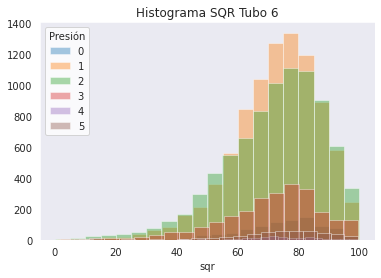

In [60]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 6')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show();

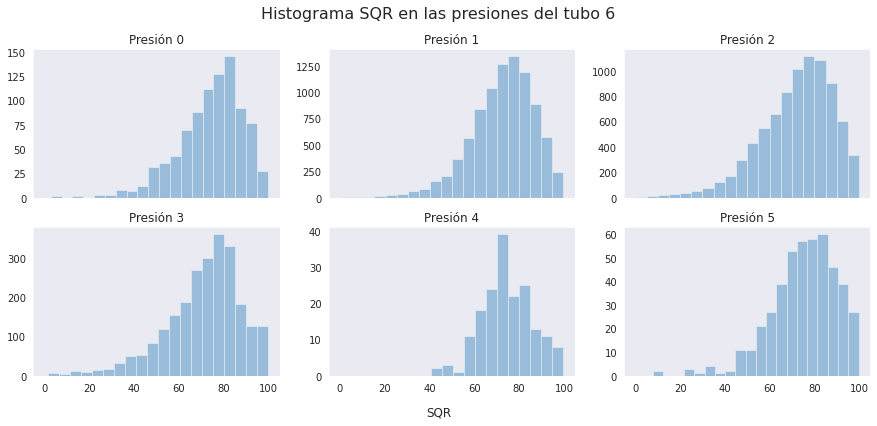

In [61]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="4",'sqr'], bins=12,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 6', fontsize=16)
plt.show();

#### Todos los tubos

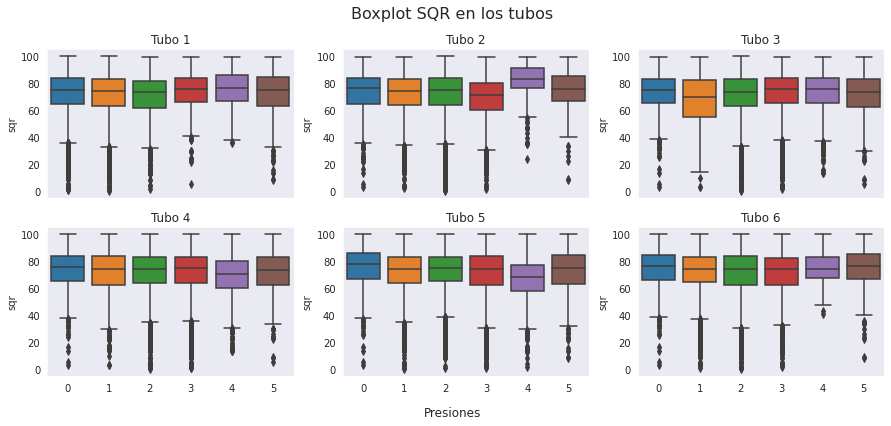

In [62]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.boxplot(x="PresPos1", y="sqr",data=perfiles_sqr,ax=axs[0, 0]).set(title = 'Tubo 1',xlabel=None)
sns.boxplot(x="PresPos2", y="sqr",data=perfiles_sqr,ax=axs[0, 1]).set(title = 'Tubo 2',xlabel=None)
sns.boxplot(x="PresPos3", y="sqr",data=perfiles_sqr,ax=axs[0, 2]).set(title = 'Tubo 3',xlabel=None)
sns.boxplot(x="PresPos4", y="sqr",data=perfiles_sqr,ax=axs[1, 0]).set(title = 'Tubo 4',xlabel=None)
sns.boxplot(x="PresPos5", y="sqr",data=perfiles_sqr,ax=axs[1, 1]).set(title = 'Tubo 5',xlabel=None)
sns.boxplot(x="PresPos6", y="sqr",data=perfiles_sqr,ax=axs[1, 2]).set(title = 'Tubo 6',xlabel=None)
fig.text(0.5, 0.04, 'Presiones', va='center', ha='center', fontsize=12)
fig.suptitle('Boxplot SQR en los tubos', fontsize=16)
plt.show();

## Análisis de SQR por categorías

A continuación se analiza la distribución del **SQR** en función de las las variables *sexo*, *posición* e *IMC*. Se obtenienen 12 categorías en función de los valores de estas variables:
* [Male Lateral Bajo peso (MLB)](#1)
* [Male Lateral Normal (MLN)](#2)
* [Male Lateral Sobrepeso (MLS)](#3)
* [Male Supine Bajo peso (MSB)](#4)
* [Male Supine Normal (MSN)](#5)
* [Male Supine Sobrepeso (MSS)](#6)
* [Female Lateral Bajo peso (FLB)](#7)
* [Female Lateral Normal (FLN)](#8)
* [Female Lateral Sobrepeso (FLS)](#9)
* [Female Supine Bajo peso (FSB)](#10)
* [Female Supine Normal (FSN)](#11)
* [Female Supine Sobrepeso (FSS)](#12)

### Box-plot

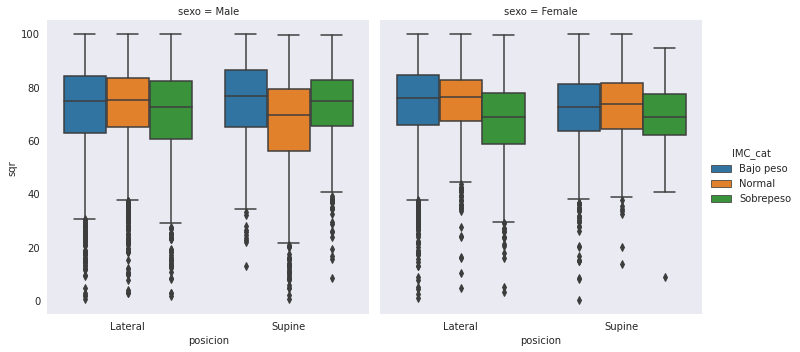

In [63]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="posicion", y="sqr", hue="IMC_cat", col="sexo",
#                 capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="box", data=perfiles_sqr)
g.despine(left=True);

En el caso de los hombres cuya posición al dormir es lateral, el sqr es algo más bajo en el caso de aquellos que padecen sobrepeso. Sin embargo, en de los que duermen en posición supina, el sqr más bajo se produce para los que tienen una complexión normal, seguidos de los que tienen sobrepeso. Finalmente, los hombres que duermen en posición supina y tienen bajo peso, obtinen un SQR más alto que todos los demás.
En el caso de las mujeres, las que duermen en posición lateral tienen una media de SQR más alta que las que duermen en posición supina. Sin embargo, en ambas posiciones, el SQR para las mujeres con sobrepeso es claramente más bajo que las mujeres con peso normal o bajo peso.

<a id="1"></a>
### MLB

#### Descriptivo general

In [64]:
display(pd.DataFrame(perfiles_sqr.query('sexo == "Male" & posicion == "Lateral" &  IMC_cat == "Bajo peso"').describe().loc[:, 'sqr']).round(2).rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns'))

,sqr
count,3048.00
mean,71.77
std,16.61
min,0.55
25%,62.62
50%,74.83
75%,84.03
max,99.72


In [65]:
presiones_cat = perfiles_sqr.query('sexo == "Male" & posicion == "Lateral" &  IMC_cat == "Bajo peso"').groupby('presiones').describe().loc[:, 'sqr']

In [66]:
presiones_cat = presiones_cat.rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia relativa'] = presiones_cat['frecuencia relativa'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia relativa', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [67]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)

In [68]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia relativa  media  desviación    min    25%  \
tipo    presiones                                                         
comunes 022332                     500  68.76       17.69   1.52  58.92   
        022321                     491  67.59       14.43   0.55  59.56   
        122332                     412  79.47       14.65  11.43  74.11   
mejores 355345                       3  98.94        0.43  98.66  98.69   
        122322                       2  94.62        3.81  91.93  93.27   
        022211                       2  88.54       15.32  77.71  83.12   
peores  011122                      68  43.19       16.31   9.39  32.42   
        000000                      14  46.89       17.92   2.77  38.26   
        023332                      27  47.03       14.45  18.84  38.20   

                     50%    75%    max  
tipo    presiones                       
comunes 022332     69.87  82.05  99.40  
        022321     69.88  77.81  99.72  
        122332     82.10  90.06  99.57  
mejores 355345     98.72  99.08  99.44  
        122322     94.62  95.96  97.31  
        022211     88.54  93.96  99.37  
peores  011122     43.78  54.99  78.73  
        000000     50.43  55.53  77.05  
        023332     46.35  56.54  77.79

<a id="2"></a>
### MLN

#### Descriptivo general

In [69]:
display(pd.DataFrame(perfiles_sqr.query('sexo == "Male" & posicion == "Lateral" &  IMC_cat == "Normal"').describe().loc[:, 'sqr'].round(2).rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')))

,sqr
frecuencia relativa,2919
media,72
desviación,15
min,2
25%,64
50%,75
75%,83
max,99


In [70]:
presiones_cat = perfiles_sqr.query('sexo == "Male" & posicion == "Lateral" &  IMC_cat == "Normal"').groupby('presiones').describe().loc[:, 'sqr'].sort_values(by='count', ascending=False).head(3)

In [71]:
presiones_cat = presiones_cat.rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia relativa'] = presiones_cat['frecuencia relativa'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia relativa', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [72]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)

In [73]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia relativa  media  desviación    min    25%  \
tipo    presiones                                                         
comunes 023321                     774  79.01       11.16  22.20  72.79   
        123333                     557  68.68       18.33   2.78  59.14   
        023332                     429  71.92       13.86  20.60  64.84   
mejores 023321                     774  79.01       11.16  22.20  72.79   
        023332                     429  71.92       13.86  20.60  64.84   
        123333                     557  68.68       18.33   2.78  59.14   
peores  123333                     557  68.68       18.33   2.78  59.14   
        023332                     429  71.92       13.86  20.60  64.84   
        023321                     774  79.01       11.16  22.20  72.79   

                     50%    75%    max  
tipo    presiones                       
comunes 023321     80.01  86.79  99.58  
        123333     72.33  80.99  99.44  
        023332     73.33  81.93  99.58  
mejores 023321     80.01  86.79  99.58  
        023332     73.33  81.93  99.58  
        123333     72.33  80.99  99.44  
peores  123333     72.33  80.99  99.44  
        023332     73.33  81.93  99.58  
        023321     80.01  86.79  99.58

<a id="3"></a>
### MLS

#### Descriptivo general

In [74]:
display(pd.DataFrame(perfiles_sqr.query('sexo == "Male" & posicion == "Lateral" &  IMC_cat == "Sobrepeso"').describe().loc[:, 'sqr'].round(2).rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')))

,sqr
frecuencia relativa,1486
media,69
desviación,16
min,1
25%,60
50%,72
75%,82
max,99


#### Análisis de presiones

In [75]:
presiones_cat = perfiles_sqr.query('sexo == "Male" & posicion == "Lateral" &  IMC_cat == "Sobrepeso"').groupby('presiones').describe().loc[:, 'sqr']

In [76]:
presiones_cat = presiones_cat.rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia relativa'] = presiones_cat['frecuencia relativa'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia relativa', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [77]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)

In [78]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia relativa  media  desviación    min    25%  \
tipo    presiones                                                         
comunes 233343                     237  65.35       19.45   1.52  54.18   
        233443                     233  64.09       13.94  12.95  56.74   
        123331                     200  78.10       15.74  10.71  71.35   
mejores 123312                       7  98.74        1.01  96.62  98.61   
        123322                       2  85.93        2.26  84.33  85.13   
        023321                     114  78.53       10.53  46.88  72.01   
peores  111111                      66  57.62       18.78   2.74  52.91   
        555555                      22  60.12       16.14   7.99  53.35   
        123332                      35  62.04       11.75  40.65  53.72   

                     50%    75%    max  
tipo    presiones                       
comunes 233343     70.26  79.60  99.30  
        233443     64.45  72.52  98.84  
        123331     83.45  89.33  98.31  
mejores 123312     99.29  99.33  99.37  
        123322     85.93  86.73  87.52  
        023321     80.28  86.22  94.77  
peores  111111     61.26  68.88  89.89  
        555555     60.21  67.63  85.34  
        123332     62.19  68.39  86.46

<a id="4"></a>
### MSB

#### Descriptivo general

In [79]:
display(pd.DataFrame(perfiles_sqr.query('sexo == "Male" & posicion == "Supine" &  IMC_cat == "Bajo peso"').describe().loc[:, 'sqr'].round(2).rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')))

,sqr
frecuencia relativa,1738
media,74
desviación,14
min,12
25%,65
50%,76
75%,86
max,99


#### Análisis de presiones

In [80]:
presiones_cat = perfiles_sqr.query('sexo == "Male" & posicion == "Supine" &  IMC_cat == "Bajo peso"').groupby('presiones').describe().loc[:, 'sqr']

In [81]:
presiones_cat = presiones_cat.rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia relativa'] = presiones_cat['frecuencia relativa'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia relativa', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [82]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)

In [83]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia relativa  media  desviación    min    25%  \
tipo    presiones                                                         
comunes 122232                     952  72.85       15.54  12.96  62.06   
        122332                     300  77.05       12.77  22.57  69.59   
        122222                     144  70.62       12.87  37.09  61.91   
mejores 344333                      91  92.96        7.46  70.01  89.52   
        555555                      37  87.51        7.35  63.77  86.08   
        333333                       8  86.64        6.91  76.06  80.17   
peores  223333                       1  55.24         NaN  55.24  55.24   
        122322                       2  60.43       12.15  51.84  56.13   
        144332                       8  64.32        7.58  54.10  60.75   

                     50%    75%    max  
tipo    presiones                       
comunes 122232     75.04  84.94  99.86  
        122332     79.74  86.65  99.36  
        122222     71.94  78.92  99.36  
mejores 344333     96.44  98.69  99.58  
        555555     90.06  91.95  97.57  
        333333     89.83  91.79  94.01  
peores  223333     55.24  55.24  55.24  
        122322     60.43  64.72  69.02  
        144332     65.35  66.94  78.07

<a id="5"></a>
### MSN

#### Descriptivo general

In [84]:
display(pd.DataFrame(perfiles_sqr.query('sexo == "Male" & posicion == "Supine" &  IMC_cat == "Normal"').describe().loc[:, 'sqr'].round(2).rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')))

,sqr
frecuencia relativa,1840
media,66
desviación,17
min,0
25%,56
50%,69
75%,79
max,99


#### Análisis de presiones

In [85]:
presiones_cat = perfiles_sqr.query('sexo == "Male" & posicion == "Supine" &  IMC_cat == "Normal"').groupby('presiones').describe().loc[:, 'sqr']

In [86]:
presiones_cat = presiones_cat.rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia relativa'] = presiones_cat['frecuencia relativa'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia relativa', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [87]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)

In [88]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia relativa  media  desviación    min    25%  \
tipo    presiones                                                         
comunes 122322                     547  66.37       15.23   7.73  57.48   
        122332                     356  57.80       19.21   0.63  46.84   
        123322                     173  69.85       17.70  11.04  60.63   
mejores 555555                       3  99.43        0.12  99.35  99.36   
        223332                      64  81.52        8.99  59.64  73.33   
        000333                       7  80.26        4.21  72.07  79.46   
peores  042233                       1  39.20         NaN  39.20  39.20   
        534451                      65  54.89       20.23  12.99  39.84   
        122332                     356  57.80       19.21   0.63  46.84   

                     50%    75%    max  
tipo    presiones                       
comunes 122322     66.96  76.93  99.37  
        122332     57.41  71.65  99.26  
        123322     74.39  82.79  94.99  
mejores 555555     99.37  99.47  99.57  
        223332     83.32  88.50  97.08  
        000333     79.59  83.44  84.40  
peores  042233     39.20  39.20  39.20  
        534451     56.92  68.67  90.81  
        122332     57.41  71.65  99.26

<a id="6"></a>
### MSS 

#### Descriptivo general

In [89]:
display(pd.DataFrame(perfiles_sqr.query('sexo == "Male" & posicion == "Supine" &  IMC_cat == "Sobrepeso"').describe().loc[:, 'sqr'].round(2).rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')))

,sqr
frecuencia relativa,586
media,72
desviación,14
min,8
25%,65
50%,74
75%,82
max,99


#### Análisis de presiones

In [90]:
presiones_cat = perfiles_sqr.query('sexo == "Male" & posicion == "Supine" &  IMC_cat == "Sobrepeso"').groupby('presiones').describe().loc[:, 'sqr']

In [91]:
presiones_cat = presiones_cat.rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia relativa'] = presiones_cat['frecuencia relativa'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia relativa', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [92]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)

In [93]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia relativa  media  desviación    min    25%  \
tipo    presiones                                                         
comunes 123322                     190  80.38        9.83  29.47  74.62   
        234443                      89  69.79       16.19  15.47  61.23   
        233333                      72  69.91       11.51  36.99  64.94   
mejores 123222                      15  83.91        4.51  69.93  82.84   
        123322                     190  80.38        9.83  29.47  74.62   
        111111                      21  76.02        9.35  55.00  69.45   
peores  042045                       5  42.05       13.02  23.84  35.11   
        000000                      27  51.06       16.45  16.51  39.72   
        233332                      32  59.14       17.82   8.40  49.69   

                     50%    75%    max  
tipo    presiones                       
comunes 123322     80.61  86.76  99.36  
        234443     70.14  82.61  99.36  
        233333     70.18  76.52  99.37  
mejores 123222     85.39  86.07  89.05  
        123322     80.61  86.76  99.36  
        111111     77.63  82.30  94.45  
peores  042045     46.07  47.24  58.01  
        000000     51.08  61.60  79.74  
        233332     59.54  71.06  85.56

<a id="7"></a>
### FLB

#### Descriptivo general

In [94]:
display(pd.DataFrame(perfiles_sqr.query('sexo == "Female" & posicion == "Lateral" &  IMC_cat == "Bajo peso"').describe().loc[:, 'sqr'].round(2).rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')))

,sqr
frecuencia relativa,5352
media,74
desviación,14
min,1
25%,65
50%,75
75%,84
max,99


#### Análisis de presiones

In [95]:
presiones_cat = perfiles_sqr.query('sexo == "Female" & posicion == "Lateral" &  IMC_cat == "Bajo peso"').groupby('presiones').describe().loc[:, 'sqr']

In [96]:
presiones_cat = presiones_cat.rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia relativa'] = presiones_cat['frecuencia relativa'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia relativa', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [97]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)

In [98]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia relativa  media  desviación    min    25%  \
tipo    presiones                                                         
comunes 012211                     855  71.81       15.27   4.40  63.89   
        022111                     782  70.57       13.01  12.97  62.23   
        012221                     782  72.40       15.53   2.32  64.13   
mejores 444444                       1  98.91         NaN  98.91  98.91   
        023112                     195  91.39        5.83  68.87  88.79   
        223344                      20  88.40        9.25  73.47  82.31   
peores  002211                      20  57.63       15.68  23.82  54.22   
        102012                      13  57.68       12.55  39.31  51.96   
        012321                      10  59.55       13.82  44.86  51.04   

                     50%    75%    max  
tipo    presiones                       
comunes 012211     73.93  82.59  99.58  
        022111     71.65  79.31  99.44  
        012221     74.56  83.65  99.26  
mejores 444444     98.91  98.91  98.91  
        023112     92.06  96.08  99.58  
        223344     91.63  96.87  99.56  
peores  002211     61.73  65.17  87.23  
        102012     56.83  61.17  84.92  
        012321     56.44  62.70  87.19

<a id="8"></a>
### FLN

#### Descriptivo general

In [99]:
display(pd.DataFrame(perfiles_sqr.query('sexo == "Female" & posicion == "Lateral" &  IMC_cat == "Normal"').describe().loc[:, 'sqr'].round(2).rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')))

,sqr
frecuencia relativa,1385
media,74
desviación,12
min,4
25%,67
50%,76
75%,82
max,99


#### Análisis de presiones

In [100]:
presiones_cat = perfiles_sqr.query('sexo == "Female" & posicion == "Lateral" &  IMC_cat == "Normal"').groupby('presiones').describe().loc[:, 'sqr']

In [101]:
presiones_cat = presiones_cat.rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia relativa'] = presiones_cat['frecuencia relativa'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia relativa', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [102]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)

In [103]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia relativa  media  desviación    min    25%  \
tipo    presiones                                                         
comunes 023211                     427  70.92       13.23   4.82  63.89   
        023321                     374  76.17       11.88  27.57  70.20   
        033211                     107  67.90       13.49  10.43  62.10   
mejores 133321                       1  99.34         NaN  99.34  99.34   
        033321                      55  86.35        7.95  68.03  81.49   
        234323                      87  85.21        7.12  63.94  79.86   
peores  023421                       2  54.29       16.62  42.54  48.41   
        012221                       1  66.31         NaN  66.31  66.31   
        133431                      20  67.62       11.20  47.19  56.59   

                     50%    75%    max  
tipo    presiones                       
comunes 023211     72.62  79.73  96.50  
        023321     77.77  83.39  99.58  
        033211     69.53  77.40  90.48  
mejores 133321     99.34  99.34  99.34  
        033321     87.83  93.03  98.78  
        234323     85.41  91.36  96.99  
peores  023421     54.29  60.17  66.05  
        012221     66.31  66.31  66.31  
        133431     71.65  75.87  83.30

<a id="9"></a>
### FLS

#### Descriptivo general

In [104]:
display(pd.DataFrame(perfiles_sqr.query('sexo == "Female" & posicion == "Lateral" &  IMC_cat == "Sobrepeso"').describe().loc[:, 'sqr'].round(2).rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')))

,sqr
frecuencia relativa,823
media,67
desviación,14
min,3
25%,58
50%,68
75%,77
max,99


#### Análisis de presiones

In [105]:
presiones_cat = perfiles_sqr.query('sexo == "Female" & posicion == "Lateral" &  IMC_cat == "Sobrepeso"').groupby('presiones').describe().loc[:, 'sqr']

In [106]:
presiones_cat = presiones_cat.rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia relativa'] = presiones_cat['frecuencia relativa'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia relativa', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [107]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)

In [108]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia relativa  media  desviación    min    25%  \
tipo    presiones                                                         
comunes 033211                     148  67.52       15.02   3.11  61.45   
        123211                     145  63.08       10.41  32.28  57.29   
        023321                     117  76.64       11.74  27.00  71.97   
mejores 123212                       9  91.04        4.61  83.73  88.72   
        000000                       1  85.16         NaN  85.16  85.16   
        023321                     117  76.64       11.74  27.00  71.97   
peores  335532                      90  55.10       13.99   5.20  48.34   
        234432                       2  56.97       15.17  46.25  51.61   
        133431                      18  59.04       22.82  15.92  39.85   

                     50%    75%    max  
tipo    presiones                       
comunes 033211     70.55  78.17  90.96  
        123211     63.58  70.62  85.73  
        023321     78.78  84.73  97.71  
mejores 123212     90.41  94.00  98.66  
        000000     85.16  85.16  85.16  
        023321     78.78  84.73  97.71  
peores  335532     56.34  65.20  83.75  
        234432     56.97  62.34  67.70  
        133431     58.44  78.56  94.84

<a id="10"></a>
### FSB

#### Descriptivo general

In [109]:
display(pd.DataFrame(perfiles_sqr.query('sexo == "Female" & posicion == "Supine" &  IMC_cat == "Bajo peso"').describe().loc[:, 'sqr'].round(2).rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')))

,sqr
frecuencia relativa,1667
media,71
desviación,13
min,0
25%,63
50%,72
75%,80
max,99


#### Análisis de presiones

In [110]:
presiones_cat = perfiles_sqr.query('sexo == "Female" & posicion == "Supine" &  IMC_cat == "Bajo peso"').groupby('presiones').describe().loc[:, 'sqr']

In [111]:
presiones_cat = presiones_cat.rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia relativa'] = presiones_cat['frecuencia relativa'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia relativa', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [112]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)

In [113]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia relativa  media  desviación    min    25%  \
tipo    presiones                                                         
comunes 122222                     718  73.14       12.92   8.12  65.49   
        122212                     242  68.98       17.57   0.02  58.00   
        122221                     196  73.82       13.65  36.55  64.98   
mejores 000002                      13  88.27        3.99  83.16  85.21   
        120022                       1  82.05         NaN  82.05  82.05   
        011111                       6  79.93       11.65  67.80  70.24   
peores  030111                       2  61.76        0.92  61.11  61.44   
        133331                     146  63.56       12.27  20.32  57.14   
        022333                      11  63.94       15.48  34.41  55.53   

                     50%    75%    max  
tipo    presiones                       
comunes 122222     74.28  81.11  99.58  
        122212     70.44  81.77  99.45  
        122221     74.22  86.33  94.23  
mejores 000002     87.74  88.81  96.16  
        120022     82.05  82.05  82.05  
        011111     78.20  88.47  95.91  
peores  030111     61.76  62.09  62.42  
        133331     66.33  71.48  89.20  
        022333     59.03  75.14  87.84

<a id="11"></a>
### FSN

#### Descriptivo general

In [114]:
display(pd.DataFrame(perfiles_sqr.query('sexo == "Female" & posicion == "Supine" &  IMC_cat == "Normal"').describe().loc[:, 'sqr'].round(2).rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')))

,sqr
frecuencia relativa,249
media,71
desviación,14
min,13
25%,64
50%,73
75%,81
max,99


#### Análisis de presiones

In [115]:
presiones_cat = perfiles_sqr.query('sexo == "Female" & posicion == "Supine" &  IMC_cat == "Normal"').groupby('presiones').describe().loc[:, 'sqr']

In [116]:
presiones_cat = presiones_cat.rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia relativa'] = presiones_cat['frecuencia relativa'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia relativa', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [117]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)

In [118]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia relativa  media  desviación    min    25%  \
tipo    presiones                                                         
comunes 122322                     160  74.32       12.22  35.27  68.19   
        123222                      47  59.62       13.06  19.98  54.10   
        110302                      17  78.03        9.66  62.60  70.53   
mejores 032325                       6  89.07        9.19  75.88  83.42   
        123322                       9  80.37        9.23  64.41  75.76   
        110302                      17  78.03        9.66  62.60  70.53   
peores  111111                       2  36.32       32.01  13.69  25.00   
        122222                       8  58.26       21.16  32.32  39.13   
        123222                      47  59.62       13.06  19.98  54.10   

                     50%    75%    max  
tipo    presiones                       
comunes 122322     76.19  81.84  99.37  
        123222     60.54  67.24  91.85  
        110302     74.64  87.37  95.41  
mejores 032325     89.75  96.05  99.58  
        123322     81.07  87.20  92.39  
        110302     74.64  87.37  95.41  
peores  111111     36.32  47.64  58.95  
        122222     61.65  71.44  92.12  
        123222     60.54  67.24  91.85

<a id="12"></a>
### FSS

#### Descriptivo general

In [119]:
display(pd.DataFrame(perfiles_sqr.query('sexo == "Female" & posicion == "Supine" &  IMC_cat == "Sobrepeso"').describe().loc[:, 'sqr'].round(2).rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns')))

,sqr
frecuencia relativa,126
media,68
desviación,11
min,8
25%,62
50%,68
75%,77
max,94


#### Análisis de presiones

In [120]:
presiones_cat = perfiles_sqr.query('sexo == "Female" & posicion == "Supine" &  IMC_cat == "Sobrepeso"').groupby('presiones').describe().loc[:, 'sqr']

In [121]:
presiones_cat = presiones_cat.rename({'count':'frecuencia relativa', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia relativa'] = presiones_cat['frecuencia relativa'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia relativa', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [122]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)

In [123]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia relativa  media  desviación    min    25%  \
tipo    presiones                                                         
comunes 555555                      65  64.91       12.10   8.86  59.24   
        122322                      16  77.71        7.34  63.20  74.49   
        010022                      13  74.27        8.60  61.01  70.78   
mejores 122322                      16  77.71        7.34  63.20  74.49   
        010022                      13  74.27        8.60  61.01  70.78   
        123332                      12  71.95       12.11  51.65  64.88   
peores  010002                       2  44.55        2.80  42.57  43.56   
        555555                      65  64.91       12.10   8.86  59.24   
        012322                       5  67.29        8.99  55.48  62.50   

                     50%    75%    max  
tipo    presiones                       
comunes 555555     67.24  70.24  91.71  
        122322     78.40  80.10  94.57  
        010022     73.34  78.84  90.86  
mejores 122322     78.40  80.10  94.57  
        010022     73.34  78.84  90.86  
        123332     70.73  81.84  89.81  
peores  010002     44.55  45.54  46.53  
        555555     67.24  70.24  91.71  
        012322     66.53  73.85  78.10

In [1]:
#Guardar en HTML sin codigo --TemplateExporter.exclude_input=True --no-input
!jupyter nbconvert Descriptivo_uni_bi.ipynb --to html --log-level WARN --TemplateExporter.exclude_input=True 